⚠️Clone the repository to use all the functions needed by the main code⚠️
---





In [1]:
try:
    import google.colab
    mode = 'colab'
except:
    mode = 'local'

if mode == 'colab':
    !git clone "https://github.com/cybernetic-m/nn-project.git"
else:
    print("You are running locally!")

You are running locally!


# IMPORT AND INITIALIZATION

In [2]:
# Import for config.yaml file
import hydra
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
from omegaconf import DictConfig
from omegaconf import OmegaConf
import yaml

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import zipfile
import shutil
from IPython.display import Audio
import random

import torch
import torch.nn as nn
import torchaudio

from torch.utils.data import Dataset, DataLoader

if mode == 'colab':
    sys.path.append('/content/nn-project/dataloader')
    sys.path.append('/content/nn-project/model')
    sys.path.append('/content/nn-project/module')
    sys.path.append('/content/nn-project/training')
    sys.path.append('/content/nn-project/testing')
    import gdown
    import utils
    import preprocessing
    import dataset
    import ctim
    import train

if mode == 'local':
    import dataloader.utils as utils
    import dataloader.dataset as dataset
    import dataloader.preprocessing as preprocessing 
    from model.ctim import CTIM
    from training.train import train as train
    from testing.test import test as test
    from dataloader.prepocessing_pipeline import preprocessing_pipeline
    from dataloader.spectogram_pipeline import spectogram_pipeline
    from dataloader.spectogram_pipeline import spectogram_pipeline




Reproducibility

In [3]:
# Set the seed
seed = 10

# Set seed for torch, numpy and random libraries
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set the devide mode on GPU (if available CUDA for Nvidia and  MPS for Apple Silicon) or CPU
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"


## Download and Split Dataset

In [4]:
link_dataset = "https://drive.google.com/file/d/1nzKBta2M3khw7Ql_S7atYg-H-bWDiOxr/view?usp=drive_link"
gdrive_link = "https://drive.google.com/uc?export=download&id="

if mode == 'colab':
    destination_dir = "/content/emovo.zip"
    extract_dir = '/content/dataset'
    emovo_data_dir = '/content/dataset/EMOVO'
elif mode == 'local':
    destination_dir = "./emovo.zip"
    extract_dir = "./dataset"
    emovo_data_dir = "./dataset/EMOVO"

utils.download_dataset(link_dataset, destination_dir, gdrive_link, extract_dir)

utils.dataset_split(emovo_data_dir, extract_dir, 0.7, 0.2, 0.1)

preprocessing_pipeline = preprocessing_pipeline(1.2, 2, 30, 30, 9600)

spectogram_pipeline = spectogram_pipeline(9600, 39, True)

utils.augment_data(preprocessing_pipeline, spectogram_pipeline, emovo_data_dir)

Dataset already downloaded
Dataset already unzipped
[Errno 17] File exists: './dataset/EMOVO_aug/train'


## Dataset Exploration

In [5]:
train_path = os.path.join(extract_dir, 'EMOVO_split', 'train')
test_path = os.path.join(extract_dir, 'EMOVO_split', 'test')
val_path = os.path.join(extract_dir, 'EMOVO_split', 'val')

train_dataset = dataset.EMOVO_Dataset(train_path, device=device)
test_dataset = dataset.EMOVO_Dataset(test_path, device=device)
val_dataset = dataset.EMOVO_Dataset(val_path, device=device)


fixed a mono track: rab-f1-b1.wav


Example of audio

Tensor of shape: torch.Size([2, 172032]) Sample Rate: 48000
Class: sor 



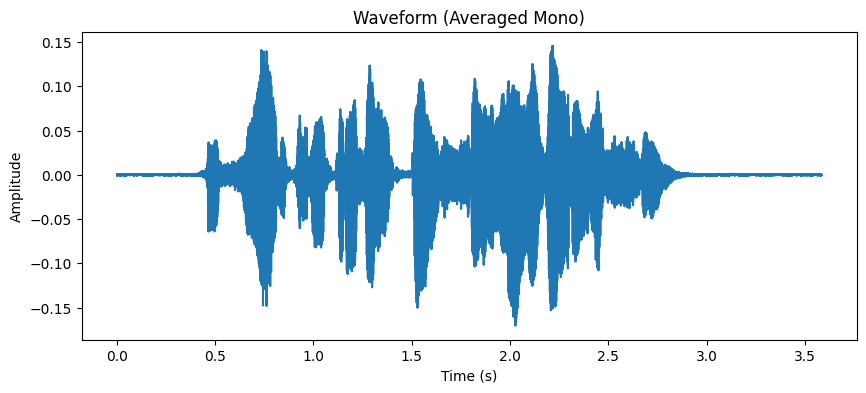

In [6]:
classes = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']
random_num = random.randint(1, train_dataset.__len__())
data, label = train_dataset[random_num]

print("Tensor of shape:",data[0].shape, "Sample Rate:", data[1])
print("Class:", classes[label], "\n")

# Waveform
# Compute the average of both channels to get a mono waveform
mono_waveform = data[0].mean(dim=0)
num_samples = mono_waveform.shape[0]
sample_rate = data[1]
time_axis = np.linspace(0, num_samples / sample_rate, num_samples)

# Play the audio
display(Audio(mono_waveform.cpu().numpy(), rate=sample_rate))

# Plot the averaged (mono) waveform
plt.figure(figsize=(10, 4))
plt.plot(time_axis, mono_waveform.cpu().numpy())
plt.title('Waveform (Averaged Mono)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


Data distribution

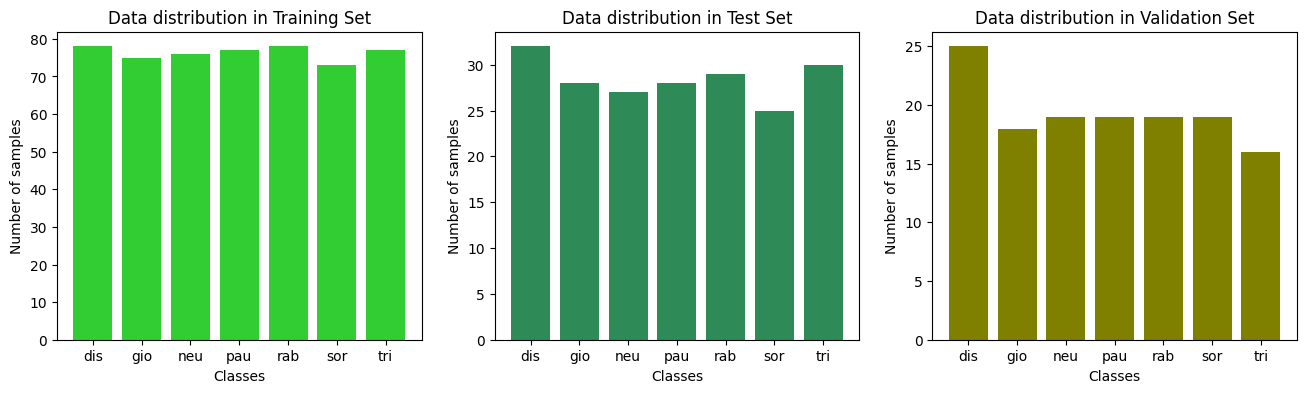

In [7]:
train_counts = train_dataset.get_info()
test_counts = test_dataset.get_info()
val_counts = val_dataset.get_info()
classes = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']


fig, ax = plt.subplots(1,3, figsize=(16, 4))

ax[0].bar(classes, train_counts, color='limegreen')
ax[0].set_title("Data distribution in Training Set")
ax[0].set_xlabel("Classes")
ax[0].set_xticks(ticks=range(7), labels=classes)
ax[0].set_ylabel("Number of samples")

ax[1].bar(classes, test_counts, color='seagreen')
ax[1].set_title("Data distribution in Test Set")
ax[1].set_xlabel("Classes")
ax[1].set_xticks(ticks=range(7), labels=classes)
ax[1].set_ylabel("Number of samples")

ax[2].bar(classes, val_counts, color='olive')
ax[2].set_title("Data distribution in Validation Set")
ax[2].set_xlabel("Classes")
ax[2].set_xticks(ticks=range(7), labels=classes)
ax[2].set_ylabel("Number of samples")
plt.show()

# HYDRA INITIALIZATION

In [8]:
# Check if Hydra is initialized
if GlobalHydra().is_initialized():
    # Clear the Hydra instance if it is initialized
    GlobalHydra.instance().clear()
    print("Hydra instance was initialized and has been cleared.")
else:
    # Initialize 
    print("Hydra now initialized!")

# Initialization
initialize(config_path="./conf", job_name="notebook_nn_exam", version_base=None)

# Load the configuration
cfg = compose(config_name="config")

Hydra now initialized!


In [9]:
# Load the hyperparameters of the model
DROPOUT_RATE = cfg.model.dropout_rate
KERNEL_SIZE = cfg.model.kernel_size
N_TAB = cfg.model.n_temporal_aware_block
N_FILTER = cfg.model.n_filter
OUTPUT_LEN = cfg.model.output_len
TAB_CONT = cfg.model.tab_cont
USE_KAN = cfg.model.use_kan

model = CTIM(
    kernel_size=KERNEL_SIZE, 
    dropout_rate=DROPOUT_RATE, 
    n_temporal_aware_block=N_TAB, 
    n_filter=N_FILTER, 
    in_channels=2,
    tab_cont=TAB_CONT,
    output_len=OUTPUT_LEN,
    num_classes = 7,
    use_kan = USE_KAN,
    device=device
)

/opt/homebrew/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


# TRAINING

In [10]:
# Load the hyperparameters for training
EPOCHS = cfg.train.num_epochs
BATCH_SIZE = cfg.train.batch_size
LEARNING_RATE = cfg.train.learning_rate
OPTI = cfg.train.optimizer
EARLY_STOPPING = cfg.train.early_stopping
PATIENCE = cfg.train.patience


LEARNING_RATElow = cfg.trainlowlr.learning_rate

LEARNING_RATEhigh = cfg.trainhighlr.learning_rate

# Initialization of the metrics' dictionary
training_metrics_dict = {
    "model" : [model.model_name],
    "epoch": [],
    "loss": [],
    "accuracy": [],
    "recall": [],
    "precision": [],
    "f1_score": [],
}
validation_metrics_dict = {
    "model" : [model.model_name],
    "epoch": [],
    "loss": [],
    "accuracy": [],
    "recall": [],
    "precision": [],
    "f1_score": [],
}

# Dataloader initialization for training, validation and test
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)#, collate_fn=utils.collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)#, collate_fn=utils.collate_fn)

# Definition of the Categorical Cross Entropy Loss
loss_fn = nn.CrossEntropyLoss() 

# Definition of the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)


In [11]:
train(EPOCHS, training_metrics_dict, validation_metrics_dict, train_dataloader, val_dataloader, model, loss_fn, optimizer)

EPOCH 1:
TRAIN:
accuracy: 14.53, precision: 14.53, recall: 14.53, f1-score: 14.53
VALIDATION:
accuracy: 15.71, precision: 15.71, recall: 15.71, f1-score: 15.71
LOSS train 1.9565858840942383 valid 1.9612995386123657
saved: /home/paolo/Downloads/magistrale/NN/nn-project/training/results/tim2024-09-23_15:20:16/model.pt
EPOCH 2:
TRAIN:
accuracy: 15.02, precision: 15.02, recall: 15.02, f1-score: 15.02
VALIDATION:
accuracy: 20.00, precision: 20.00, recall: 20.00, f1-score: 20.00
LOSS train 1.9596606492996216 valid 1.9604662656784058
saved: /home/paolo/Downloads/magistrale/NN/nn-project/training/results/tim2024-09-23_15:20:55/model.pt
EPOCH 3:
TRAIN:
accuracy: 14.29, precision: 14.29, recall: 14.29, f1-score: 14.29
VALIDATION:
accuracy: 15.71, precision: 15.71, recall: 15.71, f1-score: 15.71
LOSS train 1.9638270139694214 valid 1.9652347564697266
EPOCH 4:
TRAIN:
accuracy: 17.00, precision: 17.00, recall: 17.00, f1-score: 17.00
VALIDATION:
accuracy: 12.86, precision: 12.86, recall: 12.86, f1-sc

In [ ]:
train(EPOCHS, training_metrics_dict, validation_metrics_dict, train_dataloader, val_dataloader, model, loss_fn, optimizer)

EPOCH 1:
TRAIN:
accuracy: 14.53, precision: 14.53, recall: 14.53, f1-score: 14.53
VALIDATION:
accuracy: 15.71, precision: 15.71, recall: 15.71, f1-score: 15.71
LOSS train 1.9565858840942383 valid 1.9612995386123657
saved: /home/paolo/Downloads/magistrale/NN/nn-project/training/results/tim2024-09-23_15:20:16/model.pt
EPOCH 2:
TRAIN:
accuracy: 15.02, precision: 15.02, recall: 15.02, f1-score: 15.02
VALIDATION:
accuracy: 20.00, precision: 20.00, recall: 20.00, f1-score: 20.00
LOSS train 1.9596606492996216 valid 1.9604662656784058
saved: /home/paolo/Downloads/magistrale/NN/nn-project/training/results/tim2024-09-23_15:20:55/model.pt
EPOCH 3:
TRAIN:
accuracy: 14.29, precision: 14.29, recall: 14.29, f1-score: 14.29
VALIDATION:
accuracy: 15.71, precision: 15.71, recall: 15.71, f1-score: 15.71
LOSS train 1.9638270139694214 valid 1.9652347564697266
EPOCH 4:
TRAIN:
accuracy: 17.00, precision: 17.00, recall: 17.00, f1-score: 17.00
VALIDATION:
accuracy: 12.86, precision: 12.86, recall: 12.86, f1-sc

# TESTING

In [10]:
# Path to the model.pt 
model_path = './testing/model.pt'

# Batch size of the dataloader
BATCH_SIZE = cfg.train.batch_size

# Initialization of the dataloader
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)#, collate_fn=utils.collate_fn)

# Loss Function
loss_fn = nn.CrossEntropyLoss() 


# Initialization of the test metrics dictionary
test_metrics_dict = {
    "model" : [model.model_name],
    "epoch": [],
    "loss": [],
    "accuracy": [],
    "recall": [],
    "precision": [],
    "f1_score": [],
}

test(
    model,
    model_path, 
    test_dataloader, 
    test_metrics_dict, 
    loss_fn
)

/Users/cyber_m/Desktop/Neural Network/nn-project/model/ctim.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=torch.device('cpu

loaded: ./testing/model.pt
accuracy: 17.09, precision: 17.09, recall: 17.09, f1-score: 17.09
Metrics saved: /Users/cyber_m/Desktop/Neural Network/nn-project/testing/tim_test_metrics.json
